In [1]:
import torch.func as func
import matplotlib.pyplot as plt
import torch

Consider the function $f(x(p)) = A(x(p)+1) - b$, where $x(p)$ is the solution to a matrix equation $A(p)x=b$, and $A$ depends on parameters $p$.
The method of conjugate gradient will be used to compute $x$.

I am concerned with computing $\nabla_p f$. Some of the observations I made that might help us make progess on super resolution are the following:

1. `torch.no_grad()` only works for reverse mode, otherwise you must `.detach()` tensors.

What about the difference between using an analytical derivative?

$\frac{\partial f}{\partial p_k} = \frac{\partial A}{\partial p_k} diag(I_{50})$

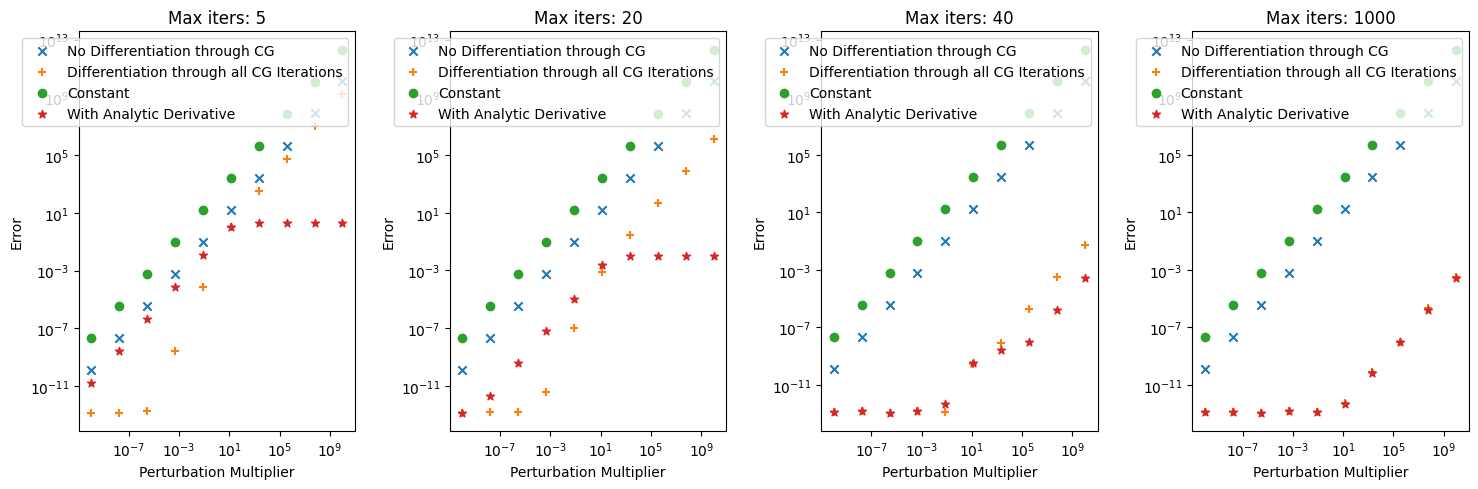

In [22]:
torch.manual_seed(0)

n = 50 
theta = torch.tensor([10.0, 5.0], requires_grad=True, dtype=torch.float64) # 2 parameters
C = torch.diag(torch.arange(1, n + 1, dtype=torch.float64))
b = torch.randn(n, dtype=torch.float64)
x0 = torch.zeros(n, dtype=torch.float64)

def conjugate_gradient(A_func, b, theta, x0, max_iter=500, tol=1e-20):
    x = x0
    r = b - A_func(theta).matmul(x)
    p = r.clone()
    rsold = r.dot(r)
    for i in range(max_iter):
        Ap = A_func(theta).matmul(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print("tol reached")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print("max iter reached")
    return x

def conjugate_gradient_nograd(A_func, b, theta, x0, max_iter=500, tol=1e-20):
    with torch.no_grad():
        x = x0.clone()
        r = b - A_func(theta).matmul(x)
        p = r.clone()
        rsold = r.dot(r)
        for i in range(max_iter):
            Ap = A_func(theta).matmul(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p 
            x = x.detach()
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        return x

def A(theta):
    return theta[0] * torch.eye(C.size(0), dtype=torch.float64) + theta[1] * C

def f(theta, max_iter):
    x = conjugate_gradient(lambda theta: A(theta), b, theta, x0, max_iter)
    return A(theta) @ (x + torch.ones_like(x, dtype=torch.float64)) - b

def f_nograd(theta, max_iter):
    x = conjugate_gradient_nograd(lambda theta: A(theta), b, theta, x0, max_iter)
    return A(theta) @ (x + torch.ones_like(x, dtype=torch.float64)) - b

dfdp1 = torch.eye(n, dtype=torch.float64) @ torch.ones(n, dtype=torch.float64)
dfdp2 = C @ torch.ones(n, dtype=torch.float64)
true_jac = torch.stack((dfdp1, dfdp2), dim=1)

# max_iters
max_iters = [5, 20, 40, 1000]

H = torch.logspace(10,-10,10)

# Number of subplots
n_plots = 4

# Create a grid of subplots
fig, axes = plt.subplots(1, n_plots, figsize=(15, 5))

# Loop through each subplot and plot
for i in range(n_plots):
    no_diffs = []
    diffs = []
    const = []
    analytic = []

    v = true_jac.T @ f(theta, max_iters[i]) # in the direction of the gradient
    v /= torch.norm(v)

    f_x = f(theta, max_iters[i])
    Jacv_nodiff = func.jacfwd(f_nograd)(theta, max_iters[i]) @ v
    Jacv = func.jacfwd(f)(theta, max_iters[i]) @ v
    Jacv_analytic = true_jac @ v

    for h in H:
        no_diffs.append(torch.norm(f(theta + h * v, max_iters[i]) - f_x - h * Jacv_nodiff).detach())
        diffs.append(torch.norm(f(theta + h * v, max_iters[i]) - f_x - h * Jacv).detach())
        const.append(torch.norm(f(theta + h * v, max_iters[i]) - f_x).detach())
        analytic.append(torch.norm(f(theta + h * v, max_iters[i]) - f_x - h * Jacv_analytic).detach())

    axes[i].scatter(H, no_diffs, marker='x', label = 'No Differentiation through CG')
    axes[i].scatter(H, diffs, marker='+', label = 'Differentiation through all CG Iterations')
    axes[i].scatter(H, const, marker='o', label = 'Constant')
    axes[i].scatter(H, analytic, marker='*', label = 'With Analytic Derivative')

    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

    axes[i].legend()

    axes[i].set_xlabel("Perturbation Multiplier")
    axes[i].set_ylabel("Error")

    axes[i].set_title(f"Max iters: {max_iters[i]}")


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()